In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Paths to dataset

In [ ]:
train_dir = "garbage_dataset/train"
validation_dir = "garbage_dataset/validation"

# Create Dataset objects

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

Found 4200 files belonging to 6 classes.
Found 600 files belonging to 6 classes.


# Get number of classes

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 6


# Preprocessing and optimization

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(1000)  # Further shuffle buffer
    .prefetch(buffer_size=AUTOTUNE)  # Prefetch for faster loading
)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

# Load MobileNet v3 (Large) without top layers

In [ ]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers with regularization and dropout

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Combine base model and custom layers

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze last 20 layers for fine-tuning

In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model with a lower learning rate

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 112, 112, 16)      │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 112, 112, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 112, 112, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 16)      │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 112, 112, 16)      │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 112, 112, 16)      │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, 112, 112, 16)      │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, 112, 112, 64)      │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, 112, 112, 64)      │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 112, 112, 64)      │               

 Total params: 3,986,566 (15.21 MB)

 Trainable params: 3,962,166 (15.11 MB)

 Non-trainable params: 24,400 (95.31 KB)

# Callbacks: Early stopping and learning rate scheduler

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * 0.1**(epoch // 10))  # Reduce LR every 10 epochs

# Train the model

In [ ]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.7176 - loss: 7.5442 - val_accuracy: 0.6150 - val_loss: 4.7450 - learning_rate: 0.0010
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.9240 - loss: 1.1563 - val_accuracy: 0.5917 - val_loss: 3.6277 - learning_rate: 0.0010
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.9450 - loss: 0.4559 - val_accuracy: 0.5433 - val_loss: 4.5161 - learning_rate: 0.0010
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.9565 - loss: 0.3316 - val_accuracy: 0.4850 - val_loss: 5.6521 - learning_rate: 0.0010
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.9631 - loss: 0.2654 - val_accuracy: 0.4983 - val_loss: 3.3123 - learning_rate: 0.0010
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.9634 - loss: 0.2270 - val_accuracy: 0.5900 - val_loss: 3.0901 - learning_rate: 0.0010
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.9616 - loss: 0.

# Plot training history

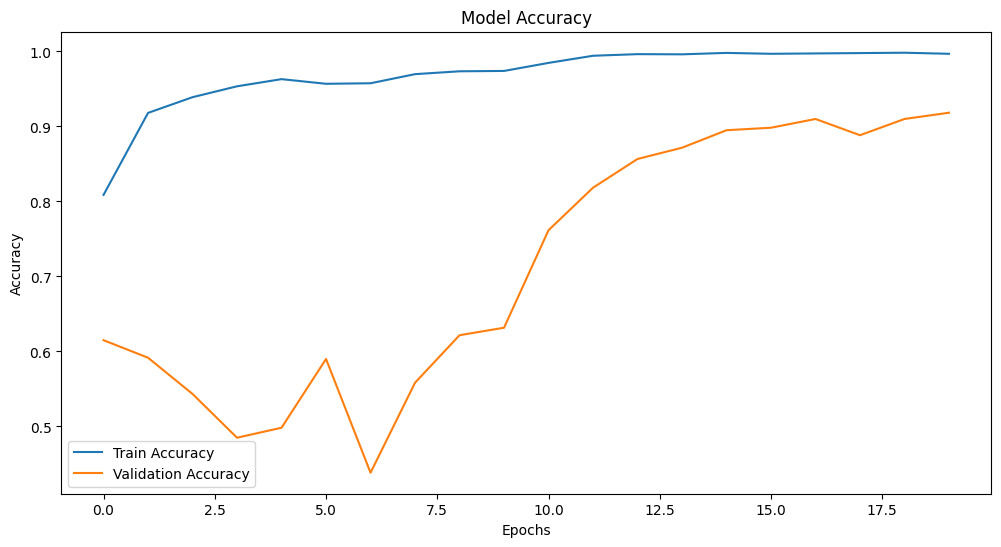

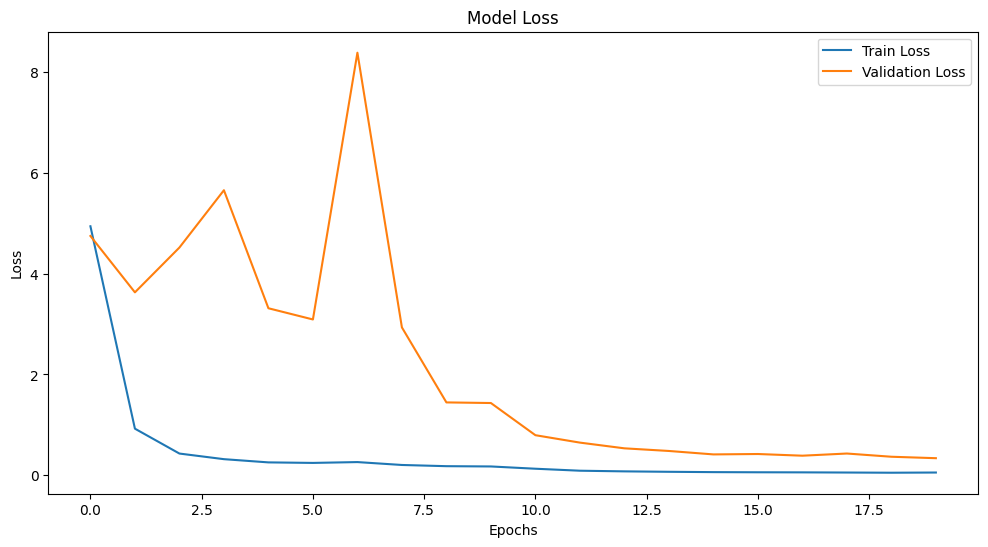

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model

In [ ]:
model.save('garbage_classification_mobilenet_v3.h5')

In [ ]:
def predict_image(image_path):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_labels = {v: k for k, v in train_ds.class_indices.items()}

    return class_labels[class_idx], predictions[0][class_idx]

In [ ]:
example_image_path = "path/to/example_image.jpg"
predicted_class, confidence = predict_image(example_image_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")